# Learn from materials data - part B
Training and test data come from different distributions.

## Get the data and look at distributions of inputs / outputs

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
from UQ_in_ML.general_utils import *
from UQ_in_ML.epistemic_regressors import *
%run /Users/audreyolivier/Documents/JHU_Research/AbaqusModel_v3/utils_v3

In [8]:
n_inputs = 4
input_names = ['$vf$', '$E_f$ (GPa)', '$b_{m}$ (MPa)', '$c_{m}$']
n_outputs = 5
output_names = ['$b_{eff}$ (MPa)', '$c_{eff}$', '$E_{eff}$ (GPa)', r'$\nu_{eff}$', '$p_{0.9 GPa}$ (%)']
a_fixed = 400.
name_ext = '_bis_a[400].pkl'

In [9]:
bounds_inputs = np.array([(0.05, 0.4), (200, 600), (300, 500), (0.2, 0.55)])
bounds_outputs = np.array([(300., 800.), (0.16, 0.5), (100., 170.), (0.277, 0.299), (0., 0.8)])
mean_outputs = np.mean(bounds_outputs, axis=-1)
coeff_var_outputs = np.array([0.03, 0.02, 0.005, 0.002, 0.25])
std_outputs = mean_outputs * coeff_var_outputs

type_norm = '[-1,1]'

#cov_aleatoric = np.array([[ 4.4e+01,  1.6e+00,  7.0e-02, -3.4e-01, 1.2e-04, -2.7e-02],
#                          [ 1.6e+00,  8.4e+01,  1.3e-02,  2.8e+00, -2.4e-03,  4.1e-01],
#                          [ 7.0e-02,  1.3e-02,  1.2e-04, -9.9e-05, -6.8e-08,  -1.7e-05],
#                          [-3.4e-01,  2.8e+00, -9.8e-05,  1.8e-01, -9.8e-05,  1.3e-02],
#                          [ 1.2e-04, -2.4e-03, -6.8e-08, -9.8e-05, 1.0e-07, -1.3e-05],
#                          [-2.7e-02,  4.1e-01,  -1.7e-05,  1.3e-02, -1.3e-05,  3.6e-03]])
#cov_aleatoric = np.array([[ 5e+01,  0.,  1e-1, 0., 0., 0.],
#                          [ 0.,  10e+01,  0.,  3e+00, -3e-03,  5e-01],
#                          [ 1e-1,  0.,  2e-04, 0., 0.,  0.],
#                          [0.,  3e+00, 0.,  2e-01, -10e-05,  2e-02],
#                          [ 0., -3e-03, 0., -10e-05, 1.5e-07, -2e-05],
#                          [0.,  5e-01,  0.,  2e-02, -2e-05,  5e-03]])
cov_aleatoric = np.diag(std_outputs ** 2)
cov_aleatoric_norm = normalize_covariance_from_bounds(cov_aleatoric, bounds_outputs, type_norm=type_norm)
print(cov_aleatoric_norm)

[[0.004356   0.         0.         0.         0.        ]
 [0.         0.00150727 0.         0.         0.        ]
 [0.         0.         0.00037194 0.         0.        ]
 [0.         0.         0.         0.00274195 0.        ]
 [0.         0.         0.         0.         0.0625    ]]


### Get the data

In [11]:
with open('Data_Abaqus_v3/training_beta' + name_ext, 'rb') as f:
    d = pickle.load(f)
    x_train, y_train = d['inpts'], d['outpts']
    print('Shape of training data: {}'.format(x_train.shape[0]))
x_train_norm = normalize_from_bounds(x_train, bounds_inputs, type_norm=type_norm)
y_train_norm = normalize_from_bounds(y_train, bounds_outputs, type_norm=type_norm)

Shape of training data: 50


In [12]:
with open('Data_Abaqus_v3/testing_random' + name_ext, 'rb') as f:
    d = pickle.load(f)
    x_test, y_test = d['inpts'], d['outpts']
    print('Shape of test data: {}'.format(x_test.shape[0]))
x_test_norm = normalize_from_bounds(x_test, bounds_inputs, type_norm=type_norm)
y_test_norm = normalize_from_bounds(y_test, bounds_outputs, type_norm=type_norm)

Shape of test data: 50


Distribution of inputs


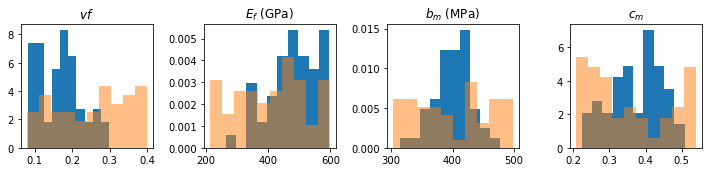

Distribution of outputs


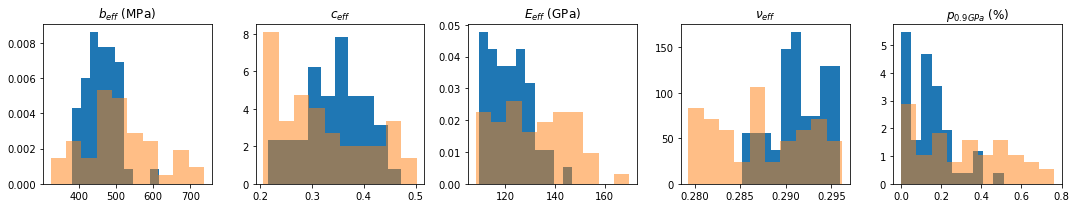

In [15]:
print('Distribution of inputs')
fig, ax = plt.subplots(ncols=4, figsize=(4 * 2.5, 2.5))
for i in range(4):
    ax[i].hist(x_train[:, i], density=True)
    ax[i].hist(x_test[:, i], density=True, alpha=0.5)
    ax[i].set_title(input_names[i])
plt.tight_layout()
plt.show(fig)

print('Distribution of outputs')
fig, ax = plt.subplots(ncols=5, figsize=(5 * 3, 3))
for i in range(5):
    ax[i].hist(y_train[:, i], density=True)
    ax[i].hist(y_test[:, i], density=True, alpha=0.5)
    ax[i].set_title(output_names[i])
plt.tight_layout()
plt.show(fig)

[48, 21, 27]
[6]
[31]
[36, 1]


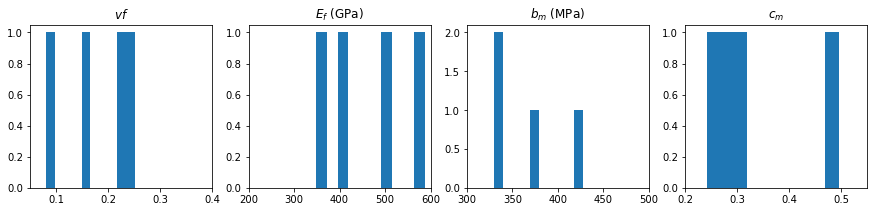

In [38]:
# Compute min distance from all pairs
from scipy.spatial.distance import cdist
min_dists = np.mean(cdist(x_test, x_train), axis=1)
sorted_ind_test = np.argsort(min_dists)

min_dists = np.amin(cdist(x_test, x_train), axis=1)
sorted_ind_test_ = np.argsort(min_dists)

l = [0, 10, 20, 30, 40]
indices_test_pts = [0] * 4
for j in range(len(indices_test_pts)):
    ll = [value for value in sorted_ind_test[l[j]:l[j+1]] if value in sorted_ind_test_[l[j]:l[j+1]]]
    print(ll)
    indices_test_pts[j] = np.random.choice(ll)
# first one: 0 or 12
# last one: 4 or 25
#print(indices_test_pts)

from scipy.stats import beta
fig, ax = plt.subplots(ncols=n_inputs, figsize=(15, 3))
#indices_test_pts = [21, 7, 29]   ####  [27, 23, 19]
indices_test_pts = [21, 6, 31, 36]
# jobs are: 5, 35, 41, 19
for n in range(n_inputs):
    ax[n].hist([x_test[i, n] for i in indices_test_pts], density=False)
    mini, maxi = bounds_inputs[n][0], bounds_inputs[n][1]
    scale = maxi - mini
    #domain = np.linspace(mini, maxi, 100)
    #ax[n].plot(domain, beta.pdf(
    #    domain, a=params_beta_inputs[n][0], b=params_beta_inputs[n][1], loc=mini, scale=scale), color='red')
    ax[n].set_title(input_names[n])
    ax[n].set_xlim([mini, maxi])
plt.show(fig)

## Setup the network and necessary functions

In [17]:
nn_kwargs = {'var_n': cov_aleatoric_norm,
             'output_dim': n_outputs,
             'input_dim': n_inputs,
             'hidden_units': (20, 20, 20),
             'activation': tf.nn.relu,
             'prior_means': 0.,
             'prior_stds': 1.}

weights_to_track = [4, 2, 4, 2, 4, 2, 4, 2]
nw = np.sum(weights_to_track)
n_layers = len(weights_to_track)//2
nw_per_layer = [weights_to_track[2*l] + weights_to_track[2*l+1] for l in range(n_layers)]
cumsum_nw_per_layer = np.cumsum([0] + nw_per_layer)

colors_layers = ['green', 'blue', 'red', 'orange', 'magenta', 'yellow', 'cyan']
markers_layers = ['o', '+', 'x', 'd', 's', 'o', '+']

In [35]:
def plot_loss(reg, epoch_start=500):
    fig, ax = plt.subplots(figsize=(10, 2.5), ncols=2)
    ax[0].plot(reg.loss_history[:])
    ax[0].set_xlabel('epochs'); ax[0].set_ylabel('loss')
    ax[1].plot(reg.loss_history[epoch_start:])
    ax[1].set_xlabel('epoch {} onwards'.format(epoch_start)); ax[1].set_ylabel('loss')
    plt.show(fig)
    return fig, ax

def plot_convergence_weights(reg):
    weights_mean = reg.variational_mu_history 
    weights_std = reg.variational_sigma_history
    fig, ax = plt.subplots(figsize=(13,  3.5), ncols=2)
    for l in range(n_layers):
        for j, (w_mean, w_std) in enumerate(zip(weights_mean.T[cumsum_nw_per_layer[l]:cumsum_nw_per_layer[l+1]], 
                                                weights_std.T[cumsum_nw_per_layer[l]:cumsum_nw_per_layer[l+1]])):
            alpha = 0.15+j*0.8/nw_per_layer[l]
            ax[0].plot(w_mean, color=colors_layers[l], alpha=alpha)
            ax[1].plot(w_std, color=colors_layers[l], alpha=alpha)
    ax[0].set_xlabel('epochs'); ax[0].set_ylabel(r'$\mu$'); 
    ax[0].set_title(r'Convergence of means $\mu_{i}$')
    ax[1].set_xlabel('epochs'); ax[1].set_ylabel(r'$\sigma$'); 
    ax[1].set_title(r'Convergence of std. devs. $\sigma_{i}$')
    return fig, ax

def plot_ystd(ytest, ypred, ystd, aleatoric_=False, outputs=(0, 1, 2, 3, 4, 5)):
    fig, ax = plt.subplots(ncols=6, figsize=(18,3.))
    for i, (y_true, y_pm, y_ps) in enumerate(zip(ytest.T, ypred.T, ystd.T)):
        bds_i = bounds_outputs[i]
        ax[i].plot([-1.05, 1.05], [-1.05, 1.05], color='gray', linestyle='--')
        ax[i].errorbar(x=y_true, y=y_pm, yerr=y_ps, xerr=y_ps, color='red', linestyle='none', 
                           label='epistemic uncertainty')
        if aleatoric_:
            ax[i].errorbar(x=y_true, y=y_pm, xerr=np.sqrt(cov_aleatoric_norm[i, i]), 
                               color='black', linestyle='none', label='aleatoric uncertainty')
        ax[i].set_xticks([-1, 0, 1])
        ax[i].set_xticklabels(['{:.3g}'.format(val) for val in [bds_i[0], (bds_i[0]+bds_i[1])/2, bds_i[1]]], fontsize=10)
        ax[i].set_xlabel('$y_{true}$', fontsize=13)
        ax[i].set_yticks([-1, 0, 1])
        ax[i].set_yticklabels(['{:.3g}'.format(val) for val in [bds_i[0], (bds_i[0]+bds_i[1])/2, bds_i[1]]], fontsize=10)
        if i == 0:
            ax[i].set_ylabel('$y_{predicted}$', fontsize=13)
        ax[i].set_title(output_names[i], fontsize=16)
        ax[i].axis('equal')
    fig.tight_layout()
    if aleatoric_:
        ax[2].legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=2, fontsize=14)
    return fig, ax

colors_data = ['green', 'blue', 'violet', 'red', 'orange']
def plot_yMC_2d(ytest, yMC, indices_test, yMCaleatoric=None):
    fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(18, 15))
    
    for n, c in zip(indices_test, colors_data[:len(indices_test)]):
        for i in range(6):
            bds_i = bounds_outputs[i]
            for j in range(i+1, 6):
                bds_j = bounds_outputs[j]
                ax[i, j].scatter(x=ytest[n, j], y=ytest[n, i], marker='s', color=c, edgecolors='black')
                ax[i, j].scatter(x=yMC[:, n, j], y=yMC[:, n, i], alpha=0.05, color=c)
                if i == 0:
                    space_ = 1.0
                    if j == 5:
                        space_ = 1.5
                    ax[i, j].text(0., space_, output_names[j], fontsize=16, horizontalalignment='center')
                    ax[i, j].set_xticks([-1, 0, 1])
                    ax[i, j].set_xticklabels(['{:.3g}'.format(val) 
                                              for val in [bds_j[0], (bds_j[0]+bds_j[1])/2, bds_j[1]]], fontsize=10)
                    ax[i, j].xaxis.tick_top()
                else:
                    ax[i, j].set_xticks([])
                if j == 4:
                    space_ = 1.05
                    if i == 0:
                        space_ = 1.4
                    ax[i, j].text(space_, 0., output_names[i], fontsize=16, verticalalignment='center',
                                 rotation=-90)
                    ax[i, j].set_yticks([-1, 0, 1])
                    ax[i, j].set_yticklabels(['{:.3g}'.format(val) 
                                              for val in [bds_i[0], (bds_i[0]+bds_i[1])/2, bds_i[1]]], fontsize=10)
                    ax[i, j].yaxis.tick_right()
                else:
                    ax[i, j].set_yticks([])
            for j in range(i+1):
                ax[i, j].axis('off')
    fig.tight_layout()
    return fig, ax

def plot_law_MC(ytest, yMC, indices_test, yMCaleatoric=None):
    fig, ax = plt.subplots(ncols=len(indices_test), figsize=(15, 3.))
    domain = np.linspace(0.0, 0.05, 100)
    for n, (i, c) in enumerate(zip(indices_test, colors_data)):
        percentiles_total = np.zeros((len(domain), 2))
        percentiles_aleatoric = np.zeros((len(domain), 2))
        for d_, d in enumerate(domain):
            law_MC = a_fixed + yMC[:, i, 0] * d ** yMC[:, i, 1]
            percentiles_total[d_, :] = np.percentile(law_MC, [2.5, 97.5])
            if yMCaleatoric is not None:
                law_MC = a_fixed + yMCaleatoric[:, i, 0] * d ** yMCaleatoric[:, i, 1]
                percentiles_aleatoric[d_, :] = np.percentile(law_MC, [2.5, 97.5])
        ax[n].fill_between(domain, percentiles_total[:, 0], percentiles_total[:, 1],
                           color='red', alpha=0.3, label='epistemic uncertainty')
        if yMCaleatoric is not None:
            ax[n].fill_between(domain, percentiles_aleatoric[:, 0], percentiles_aleatoric[:, 1],
                               color='red', alpha=0.5, label='aleatoric uncertainty')
        #for y_ in yMC:
        #    ax[n].plot(domain, y_[i, 0]+y_[i, 1]*domain**y_[i, 2], color=c, alpha=0.05)
        ax[n].plot(domain, a_fixed + ytest[i, 0] * domain ** ytest[i, 1], color='black')
        ax[n].set_xlabel(r'plastic strain $\varepsilon_{p}$', fontsize=12)
        ax[n].set_ylabel(r'stress $\sigma$ (MPa)', fontsize=12)
        ax[n].set_ylim([400, 750])
        ax[n].set_yticks([400, 500, 600, 700])
        ax[n].set_xticks([0., 0.025, 0.05])
    ax[0].legend()
    fig.tight_layout()
    return fig, ax

## Study with the BayesByBackprop algorithm

In [11]:
#regBBa = alphaBB(alpha=0.2, weights_to_track=weights_to_track, **nn_kwargs)
#regBBa = BayesByBackprop(weights_to_track=weights_to_track, **nn_kwargs)

#regBBa.fit(X=x_train_norm, y=y_train_norm, ns=20, verbose=False, epochs=12000, lr=0.005)

#fig, ax = plot_loss(regBBa)
#plt.show(fig)
#fig, ax = plot_convergence_weights(regBBa)
#plt.show(fig)

In [18]:
alpha_list = 0.1 * np.random.rand(10)
random_seed_list = generate_seeds(nseeds=len(alpha_list), nfigures=4)

model_aving_beta = ModelAveragingLOOalphaBB(
    nn_dict=nn_kwargs, training_data=(x_train_norm, y_train_norm), 
    training_dict={'ns': 20, 'epochs': 12000, 'lr': 0.005},
    n_bootstrap=100, alpha_list=alpha_list, random_seed_list=random_seed_list)

Adding model with alpha=0.03549488725694613
Adding model with alpha=0.09449069506151483
Adding model with alpha=0.062041741092419445
Adding model with alpha=0.06703681429139986
Adding model with alpha=0.08110268804490295
Adding model with alpha=0.07494864873301142
Adding model with alpha=0.020808346527951417
Adding model with alpha=0.06181588829314921
Adding model with alpha=0.07730265247346683
Adding model with alpha=0.03881247011619141


In [19]:
ypred, ystd, yMC = model_aving_beta.predict_uq(
    X=x_test_norm, ns=5000, return_std=True, return_percentiles=(), return_MC=5000, aleatoric_in_std_perc=False, 
    aleatoric_in_MC=False)

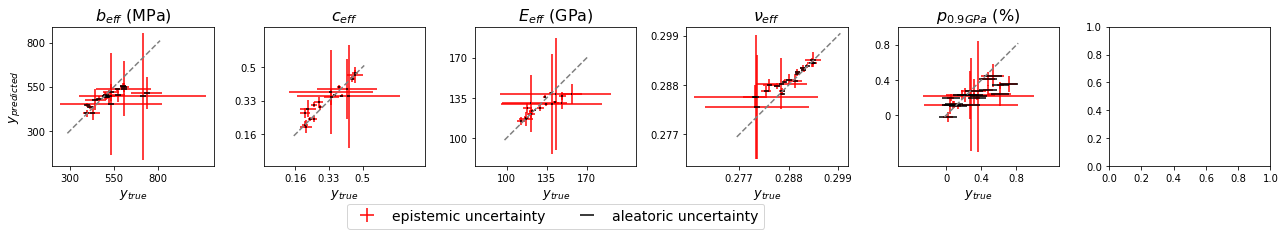

In [22]:
fig, ax = plot_ystd(y_test_norm[:20], ypred[:20], ystd[:20], aleatoric_=True)
#fig.tight_layout()
plt.show(fig)

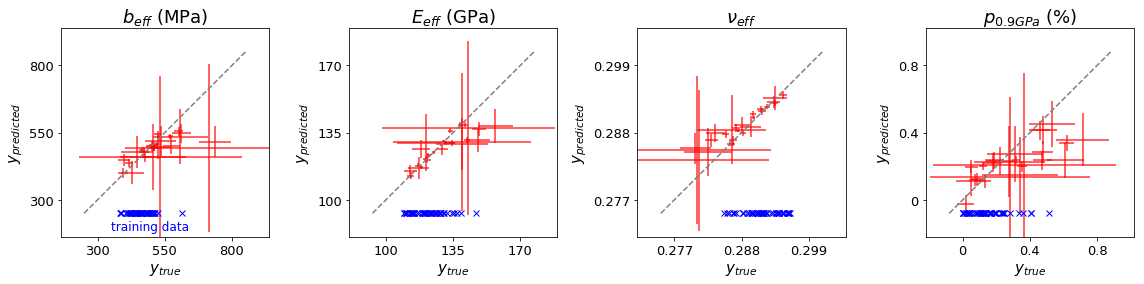

In [25]:
ypred, ystd = model_aving_beta.predict_uq(
    X=x_test_norm, ns=5000, return_std=True, return_percentiles=(), return_MC=0, aleatoric_in_std_perc=False)

n=25
fig, ax = plt.subplots(ncols=4, figsize=(16,4.))
for j, i in enumerate([0, 2, 3, 4]):
    bds_i = bounds_outputs[i]
    ax[j].plot([-1.2, 1.2], [-1.2, 1.2], color='gray', linestyle='--')
    ax[j].errorbar(x=y_test_norm[:n, i], y=ypred[:n, i], yerr=ystd[:n, i], xerr=ystd[:n, i], 
                   color='red', linestyle='none', label='epistemic uncertainty', alpha=0.8)
    #ax[i].plot([min(y_train_norm[:, i+1]), max(y_train_norm[:, i+1])], [-1.2, -1.2], linewidth=5)
    ax[j].plot(y_train_norm[:, i], -1.2*np.ones_like(y_train_norm[:, i]), linestyle='none', 
               marker='x',color='blue')
    ax[j].set_xticks([-1, 0, 1])
    ax[j].set_xticklabels(['{:.3g}'.format(val) for val in [bds_i[0], (bds_i[0]+bds_i[1])/2, bds_i[1]]], fontsize=13)
    ax[j].set_xlabel('$y_{true}$', fontsize=15)
    ax[j].set_yticks([-1, 0, 1])
    ax[j].set_yticklabels(['{:.3g}'.format(val) for val in [bds_i[0], (bds_i[0]+bds_i[1])/2, bds_i[1]]], fontsize=13)
    ax[j].set_ylabel('$y_{predicted}$', fontsize=15)
    ax[j].set_title(output_names[i], fontsize=18)
    ax[j].set_xlim([-1.55, 1.55])
    ax[j].set_ylim([-1.55, 1.55])
    ax[j].set_aspect('equal', 'box')
ax[0].text(x=-0.8, y=-1.45, s='training data', color='blue', fontsize=12)
fig.tight_layout()
#fig.savefig('PartB_beta_crosses.pdf')
plt.show()

/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in power


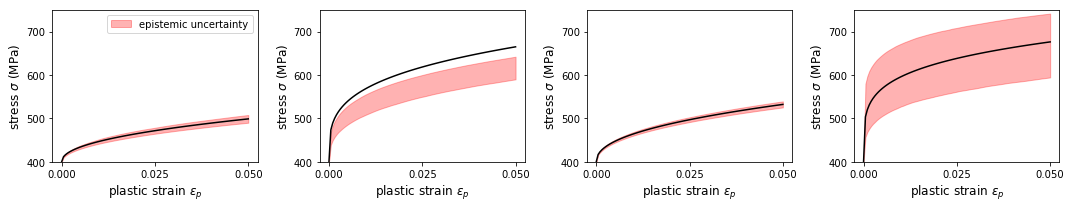

In [41]:
ypred, yMC = model_aving_beta.predict_uq(
    X=x_test_norm, ns=5000, return_std=False, return_percentiles=(), return_MC=5000, aleatoric_in_std_perc=False, 
    aleatoric_in_MC=False)

y_test_ = unnormalize_from_bounds(y_test_norm, bounds_outputs, type_norm)
yMC_ = unnormalize_from_bounds(yMC, bounds_outputs, type_norm)

fig, ax = plot_law_MC(y_test_, yMC_, indices_test=[0, 1, 2, 3])
#fig.savefig('PartB_beta_laws.pdf')
plt.show(fig)

## Compare with the other training data

In [29]:
with open('Data_Abaqus_v3/training_random' + name_ext, 'rb') as f:
    d = pickle.load(f)
    x_train_2, y_train_2 = d['inpts'][:50], d['outpts'][:50]
    print('Shape of training data: {}'.format(x_train.shape[0]))
x_train_norm_2 = normalize_from_bounds(x_train_2, bounds_inputs, type_norm=type_norm)
y_train_norm_2 = normalize_from_bounds(y_train_2, bounds_outputs, type_norm=type_norm)

Shape of training data: 50


In [30]:
#regBBa_2 = alphaBB(alpha=0.2, weights_to_track=weights_to_track, **nn_kwargs)
#regBBa = BayesByBackprop(weights_to_track=weights_to_track, **nn_kwargs)

#regBBa_2.fit(X=x_train_norm_2, y=y_train_norm_2, ns=50, verbose=False, epochs=20000, lr=0.004)

#fig, ax = plot_loss(regBBa_2)
#plt.show(fig)
#fig, ax = plot_convergence_weights(regBBa_2)
#plt.show(fig)

In [31]:
alpha_list = 0.1 * np.random.rand(10)
random_seed_list = generate_seeds(nseeds=len(alpha_list), nfigures=4)

model_aving_random = ModelAveragingLOOalphaBB(
    nn_dict=nn_kwargs, training_data=(x_train_norm_2, y_train_norm_2), 
    training_dict={'ns': 20, 'epochs': 12000, 'lr': 0.005},
    n_bootstrap=100, alpha_list=alpha_list, random_seed_list=random_seed_list)

Adding model with alpha=0.01634874841042604
Adding model with alpha=0.02842638682171288
Adding model with alpha=0.0739187097746694
Adding model with alpha=0.04754548721542038
Adding model with alpha=0.08228805202099312
Adding model with alpha=0.074890208826436
Adding model with alpha=0.07461069329539116
Adding model with alpha=0.06233638076030458
Adding model with alpha=0.06304354139628297
Adding model with alpha=0.07823941630952687


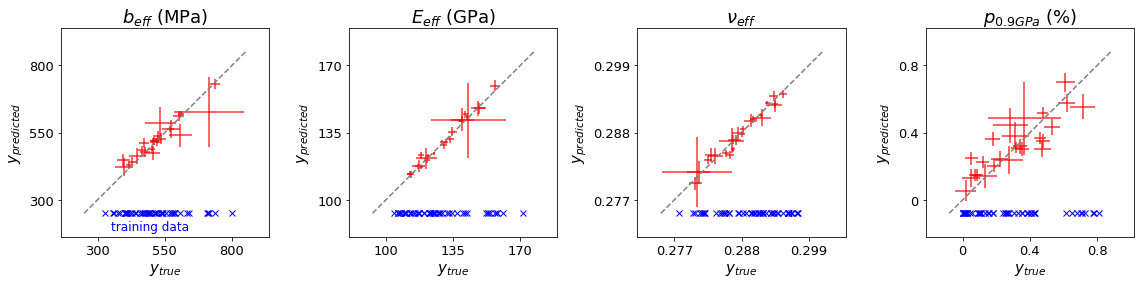

In [32]:
ypred, ystd = model_aving_random.predict_uq(
    X=x_test_norm, ns=5000, return_std=True, return_percentiles=(), return_MC=0, aleatoric_in_std_perc=False)

n=25
fig, ax = plt.subplots(ncols=4, figsize=(16,4.))
for j, i in enumerate([0, 2, 3, 4]):
    bds_i = bounds_outputs[i]
    ax[j].plot([-1.2, 1.2], [-1.2, 1.2], color='gray', linestyle='--')
    ax[j].errorbar(x=y_test_norm[:n, i], y=ypred[:n, i], yerr=ystd[:n, i], xerr=ystd[:n, i], 
                   color='red', linestyle='none', label='epistemic uncertainty', alpha=0.8)
    #ax[i].plot([min(y_train_norm[:, i+1]), max(y_train_norm[:, i+1])], [-1.2, -1.2], linewidth=5)
    ax[j].plot(y_train_norm_2[:, i], -1.2*np.ones_like(y_train_norm_2[:, i]), linestyle='none', 
               marker='x',color='blue')
    ax[j].set_xticks([-1, 0, 1])
    ax[j].set_xticklabels(['{:.3g}'.format(val) for val in [bds_i[0], (bds_i[0]+bds_i[1])/2, bds_i[1]]], fontsize=13)
    ax[j].set_xlabel('$y_{true}$', fontsize=15)
    ax[j].set_yticks([-1, 0, 1])
    ax[j].set_yticklabels(['{:.3g}'.format(val) for val in [bds_i[0], (bds_i[0]+bds_i[1])/2, bds_i[1]]], fontsize=13)
    ax[j].set_ylabel('$y_{predicted}$', fontsize=15)
    ax[j].set_title(output_names[i], fontsize=18)
    ax[j].set_xlim([-1.55, 1.55])
    ax[j].set_ylim([-1.55, 1.55])
    ax[j].set_aspect('equal', 'box')
ax[0].text(x=-0.8, y=-1.45, s='training data', color='blue', fontsize=12)
fig.tight_layout()
#fig.savefig('PartB_random_crosses.pdf')
plt.show()

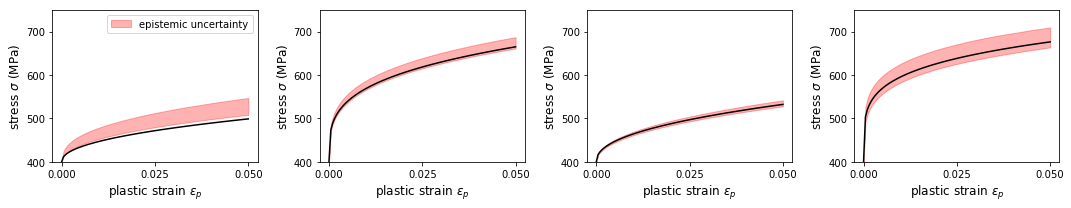

In [42]:
ypred, yMC = model_aving_random.predict_uq(
    X=x_test_norm, ns=5000, return_std=False, return_percentiles=(), return_MC=5000, aleatoric_in_std_perc=False, 
    aleatoric_in_MC=False)

y_test_ = unnormalize_from_bounds(y_test_norm, bounds_outputs, type_norm)
yMC_ = unnormalize_from_bounds(yMC, bounds_outputs, type_norm)

fig, ax = plot_law_MC(y_test_, yMC_, indices_test=[0, 1, 2, 3])
#fig.savefig('PartB_random_laws.pdf')
plt.show(fig)